### MFIN7034 Problem Set 2 – Factor and Portfolio Analysis

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
port_ret_df = pd.read_csv('data\portfolio_return_series.csv');
port_ret_df['YearMonth'] = pd.to_datetime(port_ret_df['YearMonth'])
port_ret_df.set_index('YearMonth', inplace=True)
port_ret_df = port_ret_df.apply(lambda x: x / 100)
port_ret_df.columns = port_ret_df.columns.str.strip()


In [30]:
port_ret_df.head()
port_ret_df.columns

Index(['Small-cap growth', 'Small-cap value', 'Large-cap growth',
       'Large-cap value', 'MKT'],
      dtype='object')

#### 1.1 Certainty Equivalent Rate of Return

The value of ( A ) can be calculated using the formula:

$$
A = \frac{E(R_m) - R_f}{w \cdot \text{Var}(R_m)} 
$$

where:
- $E(R_m)$ is the expected return of the market.
- $R_f$ is the risk-free rate.
- $w$  is the weight in the market index.
- $\text{Var}(R_m)$ is the variance of the market return.

Calculated A: 5.81


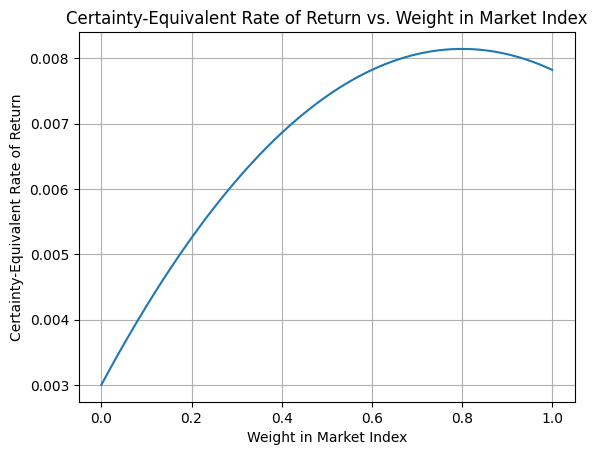

In [24]:
market_returns = port_ret_df['MKT']

# expected return and variance
E_Rm = market_returns.mean()
Var_Rm = market_returns.var()

R_f = 0.003  # Risk-free rate per month in decimal
w_optimal = 0.8  # Current allocation in the market index

A = (E_Rm - R_f) / (w_optimal * Var_Rm)
print(f"Calculated A: {A:.2f}")

# Plotting the certainty-equivalent rate of return
weights = np.linspace(0, 1, 100)
U_values = weights * E_Rm + (1 - weights) * R_f - 0.5 * A * (weights**2) * Var_Rm

plt.plot(weights, U_values)
plt.xlabel('Weight in Market Index')
plt.ylabel('Certainty-Equivalent Rate of Return')
plt.title('Certainty-Equivalent Rate of Return vs. Weight in Market Index')
plt.grid(True)
plt.show()

#### 1.2 Efficient Frontier and Tangent Portfolio

In [26]:
# Function to simulate portfolios
def simulate_portfolios(returns, num_portfolios=10000, constraints=None):
    num_assets = returns.shape[1]
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        if constraints == 'long_only':
            weights /= np.sum(weights)
        elif constraints == 'bounded':
            weights = np.random.uniform(-0.5, 1.5, num_assets)
            weights /= np.sum(weights)
        
        weights_record.append(weights)
        portfolio_return = np.sum(weights * returns.mean()) * 12
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 12, weights)))
        results[0,i] = portfolio_return
        results[1,i] = portfolio_std_dev
        results[2,i] = (portfolio_return - R_f * 12) / portfolio_std_dev

    return results, weights_record

# Function to plot the efficient frontier
def plot_efficient_frontier(results, weights_record, returns, scenario):
    max_sharpe_idx = np.argmax(results[2])
    max_sharpe_return = results[0, max_sharpe_idx]
    max_sharpe_std_dev = results[1, max_sharpe_idx]
    max_sharpe_weights = weights_record[max_sharpe_idx]

    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o', s=10, alpha=0.3)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_std_dev, max_sharpe_return, c='red', marker='*', s=500, label='Tangent Portfolio')
    plt.title(f'Efficient Frontier for Scenario {scenario}')
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Return')
    plt.legend(labelspacing=0.8)
    plt.show()

    print(f"Tangent Portfolio Weights for Scenario {scenario}:")
    for i, col in enumerate(returns.columns):
        print(f"{col}: {max_sharpe_weights[i]:.2f}")

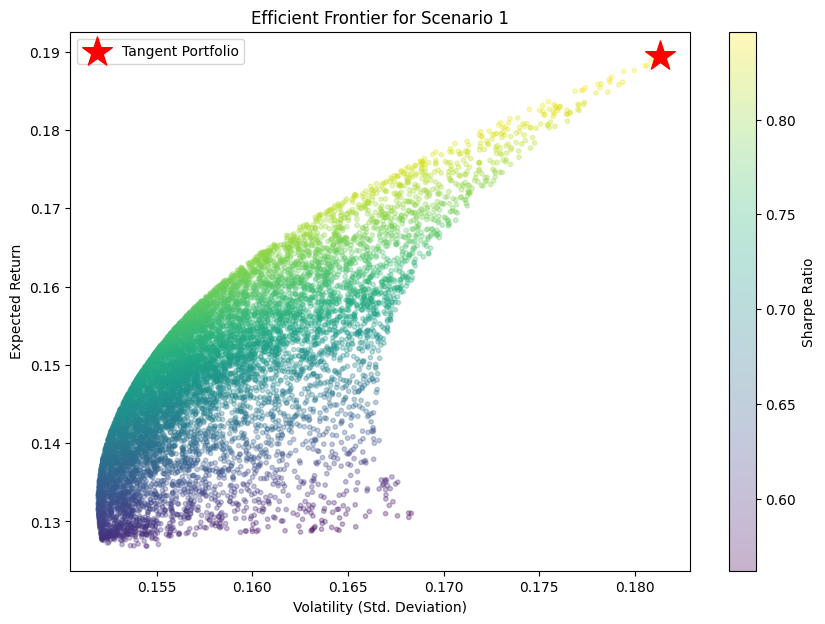

Tangent Portfolio Weights for Scenario 1:
MKT: 0.99
Large-cap growth: 0.01
Large-cap value: 0.00


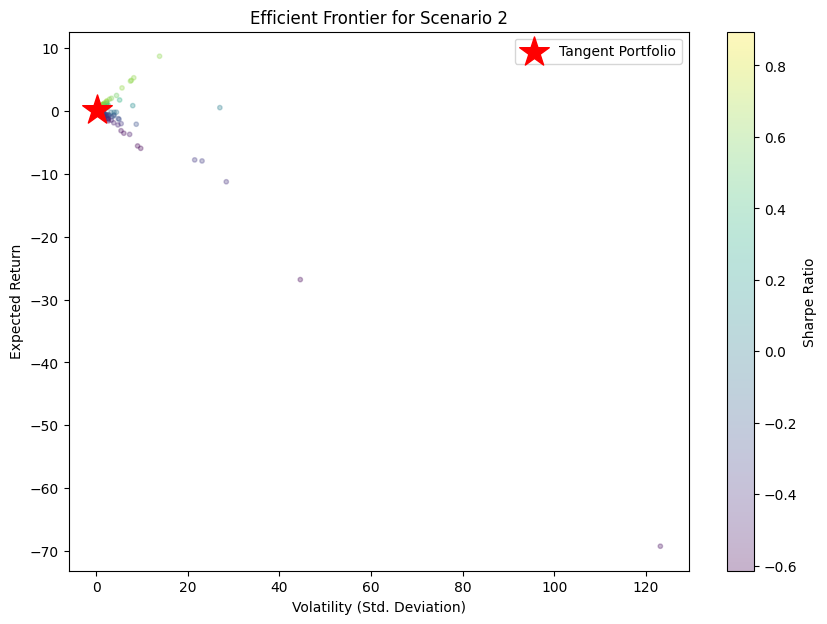

Tangent Portfolio Weights for Scenario 2:
MKT: 1.57
Large-cap growth: 0.18
Large-cap value: -0.75


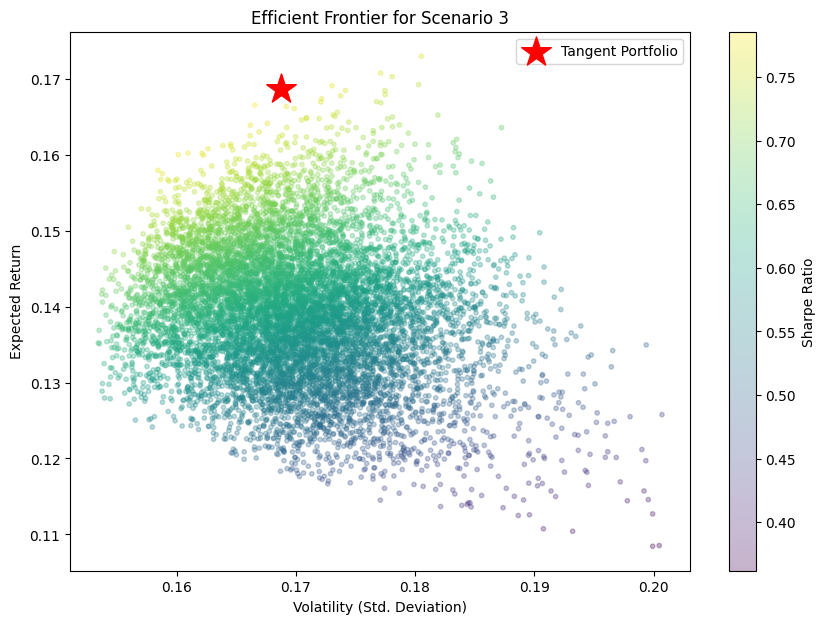

Tangent Portfolio Weights for Scenario 3:
MKT: 0.60
Large-cap growth: 0.21
Large-cap value: 0.02
Small-cap growth: 0.01
Small-cap value: 0.16


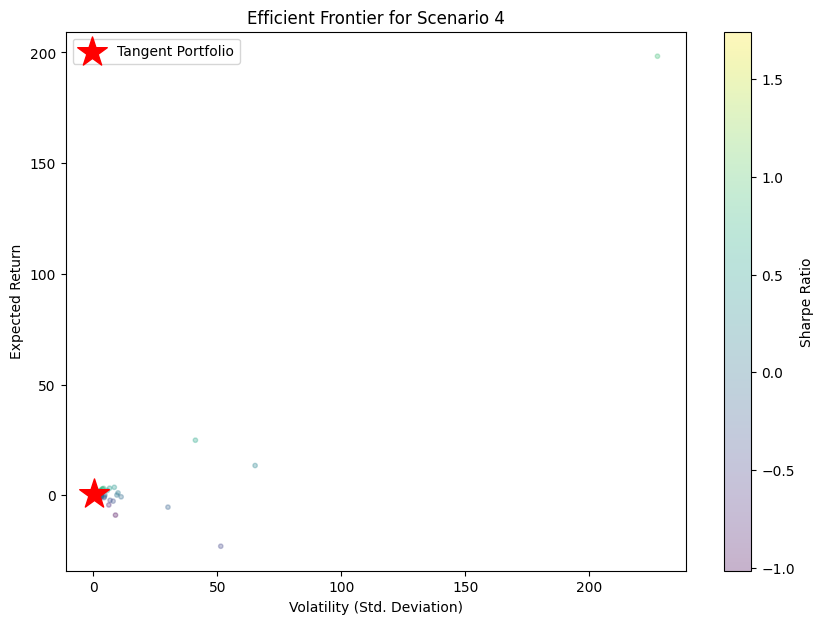

Tangent Portfolio Weights for Scenario 4:
MKT: 3.36
Large-cap growth: 1.70
Large-cap value: -1.63
Small-cap growth: -1.62
Small-cap value: -0.80


In [31]:
# Scenarios
scenarios = [
    ('long_only', ['MKT', 'Large-cap growth', 'Large-cap value']),
    ('bounded', ['MKT', 'Large-cap growth', 'Large-cap value']),
    ('long_only', ['MKT', 'Large-cap growth', 'Large-cap value', 'Small-cap growth', 'Small-cap value']),
    ('bounded', ['MKT', 'Large-cap growth', 'Large-cap value', 'Small-cap growth', 'Small-cap value'])
]

# Run each scenario
for i, (constraint, assets) in enumerate(scenarios, 1):
    selected_returns = port_ret_df[assets]
    results, weights_record = simulate_portfolios(selected_returns, constraints=constraint)
    plot_efficient_frontier(results, weights_record, selected_returns, i)